In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.style.use('seaborn')

In [2]:
  ##Weather information
main_weather_info = pd.read_csv('weather_train.csv')
main_weather_info.timestamp = pd.to_datetime(main_weather_info.timestamp)

  ##Training Information
main_training = pd.read_csv('train.csv')
main_training.timestamp = pd.to_datetime(main_training.timestamp)
main_training.meter = main_training.meter.astype('category')

  ## Building Meta Data
building_info = pd.read_csv('building_metadata.csv')

##Putting the datasets together
data_train = pd.merge(main_training,building_info,on='building_id',how='left')
data_train = pd.merge(data_train,main_weather_info,on=['site_id','timestamp'],how='left')
#Deleting the dataframe to free up memory
del main_training,main_weather_info


FileNotFoundError: [Errno 2] File b'weather_train.csv' does not exist: b'weather_train.csv'

In [ ]:
#Formatting the date properly
data_train['primary_use'] = data_train['primary_use'].astype('category').cat.codes
if data_train["timestamp"].dtype=='O':
    data_train["timestamp"] = pd.to_datetime(data_train["timestamp"])

data_train["second"] = data_train["timestamp"].dt.second
data_train["minute"] = data_train["timestamp"].dt.minute
data_train["hour"] = data_train["timestamp"].dt.hour
data_train["day"] = data_train["timestamp"].dt.day
data_train["month"] = data_train["timestamp"].dt.month
data_train["year"] = data_train["timestamp"].dt.year
data_train.drop("timestamp",axis=1,inplace= True)
data_train.fillna(0,inplace=True)


In [ ]:
#Separating X AND Y
target_col = 'meter_reading'
Ys = data_train[target_col]
Xs = data_train.drop(target_col,axis=1)


In [ ]:
#Data Normalization, also dropping the building id
from sklearn.preprocessing import StandardScaler
Normalizer = StandardScaler()
Xs =  pd.DataFrame(Normalizer.fit_transform(Xs.drop(["building_id"],axis = 1),),
        columns=['meter', 'site_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage','dew_temperature', 
                 'precip_depth_1_hr', 
                 'sea_level_pressure','wind_direction',
                 'wind_speed', 'year', 'month','day','hour','minute','second'])

In [3]:
Xs.shape

NameError: name 'Xs' is not defined

In [7]:
#Converting to Numpy then later torch tensors
X = Xs.to_numpy()
Y = Ys.to_numpy()
print(X.shape)
X = X.astype('float64')
Y = Y.astype('float64')

(20216100, 19)


In [8]:
#To free up memory
del Xs
del Ys
del data_train

In [3]:
import pandas as pd 
import torch
from torch import nn
from torch import utils
from torch.utils.data import DataLoader
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F


In [10]:
class  Training_DataSet(Dataset):
    def __init__(self,X,Y,transform):
        self.data_features = X
        self.data_target = Y
        self.transform = transform
        
    def __len__(self):
        return(len(self.data_target))
    
    def __getitem__(self,idx):
        features = self.data_features[idx]  
        target = self.data_target[idx]
        sample = {"features":features,"target":target}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [11]:

class to_tensor_training(object):
    def __call__(self,sample):
        features , target = sample['features'],sample['target']
        features = np.array([features])
        features = features.astype('float32')
        features = torch.from_numpy(features)
        features = features.float()
        torch.set_printoptions(precision=2,sci_mode=False)
        #Target
        target = np.array([target])
        target = torch.from_numpy(target)
        target = target.float()
        
        return {"features":features,"target":target}
        

In [12]:
transformed_dataset = Training_DataSet(X,
                                       Y,
                                       transform = to_tensor_training())
trainloader = torch.utils.data.DataLoader(transformed_dataset,batch_size=64, shuffle=True,num_workers=2)


In [13]:
#Sampling some data for testing
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['features'].shape,sample['target'].shape)
    print(i, sample['features'])

    if i == 0:
        break

0 torch.Size([1, 19]) torch.Size([1])
0 tensor([[-0.71, -1.57, -0.92, -0.86,  1.27, -0.32,  0.83,  2.42,  1.21, -0.10,
          0.27, -1.35, -1.47,  0.00,  0.00, -1.66, -1.67, -1.62,  0.00]])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(19,128)
        self.fc2 = nn.Linear(128,1)
        
    def forward(self,x):
        #drouput_activation1 = nn.Dropout(p=0.3)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        return x

net = Net()
print(net(sample['features']))

In [17]:
class RMSLE(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,prediction,target):
        #prediction = (prediction )
        #target = (target )
        
        result = (prediction - target) *  (prediction - target)
        mean_sqrt = torch.sqrt(torch.mean(result))
        return  mean_sqrt
    


#Testing the Loss function
criterion = RMSLE()
a = net(sample['features'])
b =net(sample['features'])
print(a)
print(b)
loss = criterion(a,b)
loss.backward()
print(loss)
    

tensor([[0.11]], grad_fn=<AddmmBackward>)
tensor([[0.11]], grad_fn=<AddmmBackward>)
tensor(0., grad_fn=<SqrtBackward>)


In [18]:
criterion = RMSLE()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion2 = nn.MSELoss()

In [ ]:
start_time = datetime.now()

loss_array = []
accuracy_array = []
for epoch in range(15):
    running_loss = 0
    for i , data in enumerate(trainloader,0):
        features , target = data['features'],data['target']
        optimizer.zero_grad()
        outputs = net(features)
        outputs = outputs.squeeze()
        outputs = outputs.unsqueeze(1)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    loss_array.append(running_loss / len(trainloader))
    
    print("Epoch: {}/ 10.. ".format(epoch+1),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)))
end_time = datetime.now()
print("Finished training")
print('Duration: {}'.format(end_time - start_time))


In [ ]:
# Let us plot our loss over time
%matplotlib inline
%config InlineBackend.figure_format = "retina"


import matplotlib.pyplot as plt

plt.plot(loss_array,label="Training_loss")
plt.legend(frameon=False)

In [21]:
# To save the Network Parameters
torch.save(net, 'best.pt')

In [7]:
#Loading a saved model(Uncomment if the model is already saved)
#net = Net()
#net = torch.load("best.pt")

In [10]:
##TESTING PHASE
#testting data
main_test_set = pd.read_csv('test.csv')

#Weather data
test_weather_info = pd.read_csv('weather_test.csv')

# Buuilding meta data
building_info = pd.read_csv('building_metadata.csv')

#merging the test and the the weather data
data_test = pd.merge(main_test_set,building_info,on='building_id',how='left')
data_test = pd.merge(data_test,test_weather_info,on=['site_id','timestamp'],how='left')
del main_test_set,test_weather_info
data_test.head()


row_id  building_id  meter            timestamp  site_id  \
41697595  41697595         1444      0  2018-05-09 07:00:00       15   
41697596  41697596         1445      0  2018-05-09 07:00:00       15   
41697597  41697597         1446      0  2018-05-09 07:00:00       15   
41697598  41697598         1447      0  2018-05-09 07:00:00       15   
41697599  41697599         1448      0  2018-05-09 07:00:00       15   

                            primary_use  square_feet  year_built  floor_count  \
41697595  Entertainment/public assembly        19619      1914.0          NaN   
41697596                      Education         4298         NaN          NaN   
41697597  Entertainment/public assembly        11265      1997.0          NaN   
41697598            Lodging/residential        29775      2001.0          NaN   
41697599                         Office        92271      2001.0          NaN   

          air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
41697595              NaN             NaN              NaN                NaN   
41697596              NaN             NaN              NaN                NaN   
41697597              NaN             NaN              NaN                NaN   
41697598              NaN             NaN              NaN                NaN   
41697599              NaN             NaN              NaN                NaN   

          sea_level_pressure  wind_direction  wind_speed  
41697595                 NaN             NaN         NaN  
41697596                 NaN             NaN         NaN  
41697597                 NaN             NaN         NaN  
41697598                 NaN             NaN         NaN  
41697599                 NaN             NaN         NaN

In [11]:
## Correctly formatting the time
data_test['primary_use'] = data_test['primary_use'].astype('category').cat.codes
if data_test["timestamp"].dtype=='O':
    data_test["timestamp"] = pd.to_datetime(data_test["timestamp"])
    
data_test["second"] = data_test["timestamp"].dt.second
data_test["minute"] = data_test["timestamp"].dt.minute
data_test["hour"] = data_test["timestamp"].dt.hour
data_test["day"] = data_test["timestamp"].dt.day
data_test["month"] = data_test["timestamp"].dt.month
data_test["year"] = data_test["timestamp"].dt.year
data_test.drop("timestamp",axis=1,inplace= True)
data_test.fillna(0,inplace=True)
data_test.fillna(0,inplace=True)
ids = data_test['row_id']
data_test.drop('row_id',axis=1,inplace=True)
data_test.head()



building_id  meter  site_id  primary_use  square_feet  year_built  \
0            0      0        0            0         7432      2008.0   
1            1      0        0            0         2720      2004.0   
2            2      0        0            0         5376      1991.0   
3            3      0        0            0        23685      2002.0   
4            4      0        0            0       116607      1975.0   

   floor_count  air_temperature  cloud_coverage  dew_temperature  \
0          0.0             17.8             4.0             11.7   
1          0.0             17.8             4.0             11.7   
2          0.0             17.8             4.0             11.7   
3          0.0             17.8             4.0             11.7   
4          0.0             17.8             4.0             11.7   

   precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  second  \
0                0.0              1021.4           100.0         3.6       0   
1                0.0              1021.4           100.0         3.6       0   
2                0.0              1021.4           100.0         3.6       0   
3                0.0              1021.4           100.0         3.6       0   
4                0.0              1021.4           100.0         3.6       0   

   minute  hour  day  month  year  
0       0     0    1      1  2017  
1       0     0    1      1  2017  
2       0     0    1      1  2017  
3       0     0    1      1  2017  
4       0     0    1      1  2017

In [12]:
#Data Normalization, also dropping the building id
from sklearn.preprocessing import StandardScaler
Normalizer = StandardScaler()
data_test =  pd.DataFrame(Normalizer.fit_transform(data_test.drop(["building_id"],axis = 1),),
        columns=['meter', 'site_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'air_temperature', 'cloud_coverage','dew_temperature', 
                 'precip_depth_1_hr', 
                 'sea_level_pressure','wind_direction',
                 'wind_speed', 'year', 'month','day','hour','minute','second'])

In [13]:
my_training = data_test.to_numpy()
my_training = torch.from_numpy(my_training)
my_training = my_training.float()

In [14]:
print(my_training.shape)

torch.Size([41697600, 19])


In [15]:
predictions = net(my_training)

In [16]:
np.set_printoptions(suppress=True)

In [17]:
predictions_real = predictions.detach().numpy()

In [ ]:
result = pd.DataFrame()
result['row_id'] = ids
result['meter_reading'] = predictions_real
result.to_csv('NNSubmition.csv',index=False)
result.head()


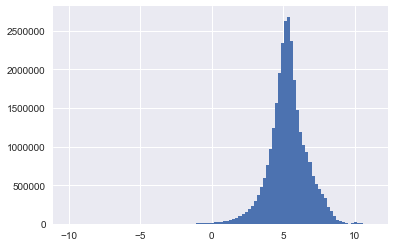

In [19]:
#Show the histogram of the predictions
plt.hist(np.log1p(result['meter_reading']),bins=100)
plt.show()